### Example 00 - Lock
In this example we will discuss how to implement a lock in OpenTNSim and how to analyse specific locking output.

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# OpenTNSIM
from opentnsim import corelock5 as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

### Create Graph
Basics are the same. However, instead here it is chosen to build a graph with distances, as it is more convenient to impose a lock with certain dimensions on such a graph.

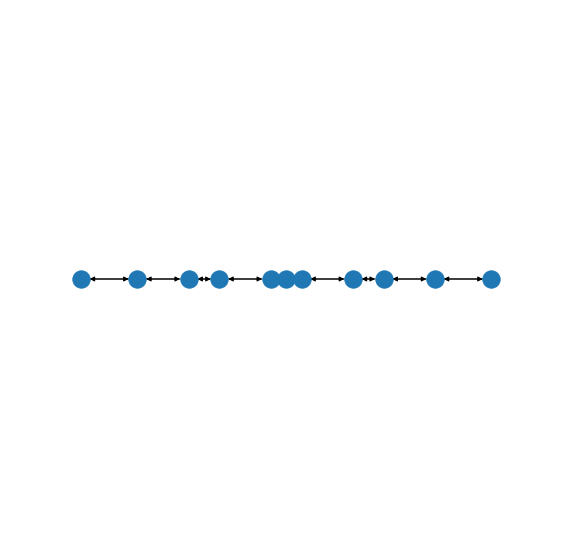

In [2]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []

distances = [550,500,300,500,150,150,500,300,500,550]
coords = []
coords.append([0,0])

for d in range(len(distances)):
    coords.append([pyproj.Geod(ellps="WGS84").fwd(coords[d][0],coords[d][1],90,distances[d])[0],0])

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node " + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)

for i in range(2):
    if i == 0:
        for j in range(len(nodes)-1):
            path.append([nodes[j], nodes[j+1]])
    if i == 1:
        for j in range(len(nodes)-1):
            path.append([nodes[j+1], nodes[j]])
    
FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(FG, positions,ax=ax)
plt.show()

### Define start of simulation
This is done earlier and separate of the definition of the simulation, as the next step is to impose the lock complex on the network, which uses the simulation environment.

In [3]:
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

### Define lock
A lock complex consists of a lock chamber, and a waiting area and line-up area on both sides of the chamber. You need to impose certain parameters.

In [4]:
waiting_area_1 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                        name = 'Volkeraksluizen_1', node = "Node 2")

lineup_area_1 = core.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                      name = 'Volkeraksluizen_1', node = "Node 3", lineup_length = 300)

lock_1 = core.IsLock(env = env, nr_resources = 100, priority = True, name = 'Volkeraksluizen_1',            
                     node_1 = "Node 5", node_2 = "Node 6", node_3 = "Node 7",
                     lock_length = 300, lock_width = 24, lock_depth = 4.5, 
                     doors_open = 10 * 60, doors_close = 10 * 60, wlev_dif = 2.0, disch_coeff = 0.8,
                     grav_acc = 9.81, opening_area = 4.0, opening_depth = 5.0,
                     simulation_start = simulation_start, operating_time = 25*60)
                                      
waiting_area_2 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                        name = "Volkeraksluizen_1", node = "Node 10")

lineup_area_2 = core.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                        name = "Volkeraksluizen_1", node = "Node 9", lineup_length = 300)

Now, we need to impose the areas on the graph.

In [5]:
lock_1.water_level = "Node 5"
FG.nodes["Node 6"]["Lock"] = [lock_1]

FG.nodes["Node 2"]["Waiting area"] = [waiting_area_1]
FG.nodes["Node 3"]["Line-up area"] = [lineup_area_1]

FG.nodes["Node 10"]["Waiting area"] = [waiting_area_2]
FG.nodes["Node 9"]["Line-up area"] = [lineup_area_2] 

### Create vessels

In [6]:
TransportResource = type('Vessel', 
                         (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, core.Routeable, core.VesselProperties), {})

start_point = 'Node 1' 
end_point = 'Node 11'  

data_vessel = {"env": env,
               "name": "Vessel",
               "route": nx.dijkstra_path(FG, start_point, end_point, weight='length'),
               "geometry": FG.nodes[start_point]['geometry'],
               "capacity": 1_000,
               "vessel_type": 'CEMT - Va',
               "width": 11.40,
               "height_empty": 7.10, 
               "height_full": 5.40,
               "draught_empty": 1.8,
               "draught_full": 3.5,
               "length": 135.0}          

vessel = TransportResource(**data_vessel)

### Define path

In [7]:
path = nx.dijkstra_path(FG, start_point, end_point)

### Run Simulation

In [8]:
# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
vessels = []

vessel.env = env                                        #the created environment
vessel.name = 'Vessel No.1'                     
vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)

vessels.append(vessel)

# Start the simulation
for vessel in vessels:
    vessel.env = env
    env.process(vessel.move())
env.run()

### Output

In [9]:
df = pd.DataFrame.from_dict(vessels[0].log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node Node 1 to node Node 2 start,2021-05-26 13:02:56.000000,0.000000,POINT (0 0)
1,Sailing from node Node 1 to node Node 2 stop,2021-05-26 13:05:13.500000,0.000000,POINT (0.004940734062657368 0)
2,Sailing from node Node 2 to node Node 3 start,2021-05-26 13:05:13.500000,0.000000,POINT (0.004940734062657368 0)
3,Sailing from node Node 2 to node Node 3 stop,2021-05-26 13:11:19.750000,0.000000,POINT (0.01152089351883286 0)
4,Sailing from node Node 3 to node Node 4 start,2021-05-26 13:11:19.750000,0.000000,POINT (0.01152089351883286 0)
5,Sailing from node Node 3 to node Node 4 stop,2021-05-26 13:12:27.250000,0.000000,POINT (0.01212725633561354 0)
6,Sailing from node Node 4 to node Node 5 start,2021-05-26 13:12:27.250000,0.000000,POINT (0.01212725633561354 0)
7,Sailing from node Node 4 to node Node 5 stop,2021-05-26 13:20:47.250000,0.000000,POINT (0.01661883275621115 0)
8,Sailing from node Node 5 to node Node 6 start,2021-05-26 13:20:47.250000,0.000000,POINT (0.01661883275621115 0)
9,Sailing from node Node 5 to node Node 6 stop,2021-05-26 13:24:39.750000,0.000000,POINT (0.01870741579178903 0)


In [10]:
locking_cycle_start_dir1 = simulation_start.timestamp()
locking_cycle_starts_dir1 = []
locking_cycle_stop_dir1 = simulation_start.timestamp()
locking_cycle_stops_dir1 = []
locking_cycle_start_dir2 = simulation_start.timestamp()
locking_cycle_starts_dir2 = []
locking_cycle_stop_dir2 = simulation_start.timestamp()
locking_cycle_stops_dir2 = []

for v in range(0,len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].route[0] == 'Node 1':
            if vessels[v].log["Message"][t] == "Passing lock start":
                if locking_cycle_start_dir1 <= vessels[v].log["Timestamp"][t].timestamp() <= locking_cycle_stop_dir1:
                    pass
                else:
                    locking_cycle_start_dir1 = vessels[v].log["Timestamp"][t-2].timestamp()
                    locking_cycle_starts_dir1.append([vessels[v].log["Timestamp"][t-2].timestamp(),'Start'])
                    locking_cycle_stop_dir1 = vessels[v].log["Timestamp"][t+1].timestamp()
                    for v2 in (range(v,len(vessels))):
                        for t2 in range(0,len(vessels[v2].log["Message"])-1):
                            if vessels[v2].log["Message"][t2] == 'Passing lock stop':
                                if locking_cycle_start_dir1 <= vessels[v2].log["Timestamp"][t2-1].timestamp() <= locking_cycle_stop_dir1 and vessels[v2].route[0] == 'Node 1':                               
                                    if len(locking_cycle_starts_dir1) != len(locking_cycle_stops_dir1):
                                        locking_cycle_stops_dir1.append([vessels[v2].log["Timestamp"][t2+2].timestamp(),'Stop'])
                                    elif vessels[v2].log["Timestamp"][t2+2].timestamp() > locking_cycle_stops_dir1[-1][0]:
                                        locking_cycle_stops_dir1[-1][0] = vessels[v2].log["Timestamp"][t2+2].timestamp()

        elif vessels[v].route[0] == 'Node 21': 
            if vessels[v].log["Message"][t] == "Passing lock start":
                if locking_cycle_start_dir2 <= vessels[v].log["Timestamp"][t].timestamp() <= locking_cycle_stop_dir2:
                    pass
                else:
                    locking_cycle_start_dir2 = vessels[v].log["Timestamp"][t-2].timestamp()
                    locking_cycle_starts_dir2.append([vessels[v].log["Timestamp"][t-2].timestamp(),'Start'])
                    locking_cycle_stop_dir2 = vessels[v].log["Timestamp"][t+1].timestamp()
                    for v2 in (range(v,len(vessels))):
                        for t2 in range(0,len(vessels[v2].log["Message"])-1):
                            if vessels[v2].log["Message"][t2] == 'Passing lock stop':
                                if locking_cycle_start_dir2 <= vessels[v2].log["Timestamp"][t2-1].timestamp() <= locking_cycle_stop_dir2 and vessels[v2].route[0] == 'Node 21':                               
                                    if len(locking_cycle_starts_dir2) != len(locking_cycle_stops_dir2):
                                        locking_cycle_stops_dir2.append([vessels[v2].log["Timestamp"][t2+2].timestamp(),'Stop'])
                                    elif vessels[v2].log["Timestamp"][t2+2].timestamp() > locking_cycle_stops_dir2[-1][0]:
                                        locking_cycle_stops_dir2[-1][0] = vessels[v2].log["Timestamp"][t2+2].timestamp()

inoperation_time_doors1 = locking_cycle_starts_dir2+locking_cycle_stops_dir1
inoperation_time_doors1.sort()
inoperation_time_doors2 = locking_cycle_starts_dir1+locking_cycle_stops_dir2
inoperation_time_doors2.sort()
loop_time_doors1 = []
loop_time_doors2 = []

for i in range(len(inoperation_time_doors1)):
    if i != 0 and inoperation_time_doors1[i][1] == 'Start' and inoperation_time_doors1[i-1][1] != 'Start':
        loop_time_doors1.append((inoperation_time_doors1[i][0]-inoperation_time_doors1[i-1][0])/60)
        
for i in range(len(inoperation_time_doors2)):
    if i != 0 and inoperation_time_doors2[i][1] == 'Start' and inoperation_time_doors2[i-1][1] != 'Start':
        loop_time_doors2.append((inoperation_time_doors2[i][0]-inoperation_time_doors2[i-1][0])/60)

In [11]:
waiting_to_waiting_area = []
waiting_in_waiting_area = []
waiting_in_lineup_area = []
waiting_in_lock = []
total_waiting_time = np.zeros(len(vessels))

for v in range(0,len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop":
            waiting_to_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in waiting area stop":
            waiting_in_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in line-up area stop":
            waiting_in_lineup_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Passing lock stop":
            waiting_in_lock.append(vessels[v].log["Value"][t]/60)
            
for v in range(len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop" or vessels[v].log["Message"][t] == "Waiting in waiting area stop" or vessels[v].log["Message"][t] == "Waiting in line-up area stop" or  vessels[v].log["Message"][t] == "Passing lock stop": 
            total_waiting_time[v] += ((vessels[v].log["Value"][t]/60))

In [12]:
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(orig[0], orig[1], 
                         dest[0], dest[1])[2]
    
    return distance

vessel_path_x = []
vessel_path_t = []
origin = 'Node 1'
destination = 'Node 11'

for v in range(0,len(vessels)):
    vessel_path_xt = []
    vessel_path_tt = []
    for t in range(0,len(vessels[v].log["Message"])):
        if vessels[v].route[0] == 'Node 1':   
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
        if vessels[v].route[0] == 'Node 11':     
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(calculate_distance((env.FG.nodes[destination]['geometry'].x,env.FG.nodes[destination]['geometry'].y),(env.FG.nodes[origin]['geometry'].x,env.FG.nodes[origin]['geometry'].y))-
                                  calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
    vessel_path_x.append(vessel_path_xt)
    vessel_path_t.append(vessel_path_tt)

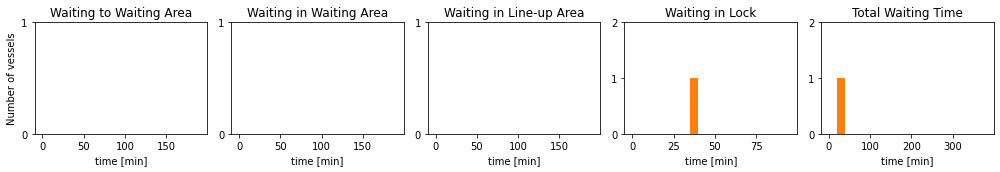

In [13]:
data= [waiting_to_waiting_area,waiting_in_waiting_area,waiting_in_lineup_area,waiting_in_lock,total_waiting_time]
xaxes = 'time [min]'
titles = ['Waiting to Waiting Area','Waiting in Waiting Area','Waiting in Line-up Area','Waiting in Lock','Total Waiting Time'] 
bins = [range(0,200,10),range(0,200,10),range(0,200,10),range(0,100,5),range(0,400,20)]

f,a = plt.subplots(1,5,figsize=(14, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Number of vessels')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

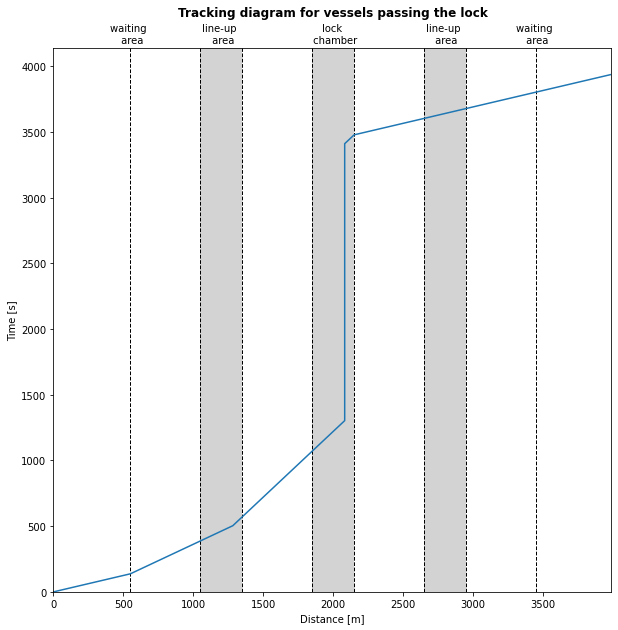

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 2"]['geometry'].x,FG.nodes["Node 2"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 5"]['geometry'].x,FG.nodes["Node 5"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
for v in reversed(range(0,len(vessels))):
    plt.plot(vessel_path_x[v],vessel_path_t[v])

plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'lock \n chamber',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y))-
         0.5*calculate_distance((FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y),(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'line-up \n area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y))+
         0.5*calculate_distance((FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y),(FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'line-up \n area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'waiting \n area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 2"]['geometry'].x,FG.nodes["Node 2"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'waiting \n area',horizontalalignment = 'center')

plt.title("Tracking diagram for vessels passing the lock", fontweight='bold', pad = 32)
plt.xlabel("Distance [m]")
plt.xlim([0,0.95*ax.get_xlim()[1]])
plt.ylim([0,ax.get_ylim()[1]])
plt.ylabel("Time [s]")

plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y))],
         [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 5"]['geometry'].x,FG.nodes["Node 5"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 5"]['geometry'].x,FG.nodes["Node 5"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y))],
         [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y))],
         [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

plt.show()

In [15]:
df = pd.DataFrame.from_dict(lock_1.log)
df

,Message,Timestamp,Value,Geometry
0,Lock doors closing start,2021-05-26 13:24:39.750000,1,Node 5
1,Lock doors closing stop,2021-05-26 13:34:39.750000,1,Node 5
2,Lock chamber converting start,2021-05-26 13:34:39.750000,1,Node 5
3,Lock chamber converting stop,2021-05-26 13:49:48.423799,1,Node 7
4,Lock doors opening start,2021-05-26 13:49:48.423799,1,Node 7
5,Lock doors opening stop,2021-05-26 13:59:48.423799,1,Node 7


In [16]:
door_open_time_doors_1 = []
door_open_time_doors_2 = []
end_time = []
for v in range(0,len(vessels)):
    end_time.append(vessels[v].log["Timestamp"][-1].timestamp())
end_of_simulation = max(end_time)

for l in range(0,len(env.FG.nodes['Node 6']['Lock'])):
    for t in range(0,len(env.FG.nodes['Node 6']['Lock'][l].log["Message"])-1):
        if env.FG.nodes['Node 6']['Lock'][l].log["Message"][t] == "Lock doors closing stop" and env.FG.nodes['Node 6']['Lock'][l].log["Geometry"][t] == 'Node 5':
            for t2 in reversed(range(0,t)):
                if env.FG.nodes['Node 6']['Lock'][l].log["Message"][t2] == "Lock doors opening start":
                    door_open_time_doors_1.append(env.FG.nodes['Node 6']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                                  env.FG.nodes['Node 6']['Lock'][l].log["Timestamp"][t2].timestamp()/60)
                    break
            else:
                door_open_time_doors_1.append(env.FG.nodes['Node 6']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                              simulation_start.timestamp()/60)
        elif env.FG.nodes['Node 6']['Lock'][l].log["Message"][t] == "Lock doors closing stop" and env.FG.nodes['Node 6']['Lock'][l].log["Geometry"][t] == 'Node 7':
            for t2 in reversed(range(0,t)):
                if env.FG.nodes['Node 6']['Lock'][l].log["Message"][t2] == "Lock doors opening start":
                    door_open_time_doors_2.append(env.FG.nodes['Node 6']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                                  env.FG.nodes['Node 6']['Lock'][l].log["Timestamp"][t2].timestamp()/60)
                    break
            else:
                door_open_time_doors_2.append(env.FG.nodes['Node 6']['Lock'][l].log["Timestamp"][t].timestamp()/60-
                                              simulation_start.timestamp()/60)

for l in range(0,len(env.FG.nodes['Node 6']['Lock'])):
    for t in reversed(range(0,len(env.FG.nodes['Node 6']['Lock'][l].log["Message"]))):
        if env.FG.nodes['Node 6']['Lock'][l].log["Message"][t] == "Lock doors opening stop" and env.FG.nodes['Node 6']['Lock'][l].log["Geometry"][t] == 'Node 5':          
            for t2 in range(t,len(env.FG.nodes['Node 6']['Lock'][l].log["Message"])):
                if env.FG.nodes['Node 6']['Lock'][l].log["Message"][t2] == "Lock doors closing stop":
                    pass
            else:
                door_open_time_doors_1.append(end_of_simulation/60-
                                              env.FG.nodes['Node 6']['Lock'][l].log["Timestamp"][t].timestamp()/60)
                break
        elif env.FG.nodes['Node 6']['Lock'][l].log["Message"][t] == "Lock doors opening stop" and env.FG.nodes['Node 6']['Lock'][l].log["Geometry"][t] == 'Node 7':          
            for t2 in range(t,len(env.FG.nodes['Node 6']['Lock'][l].log["Message"])):
                if env.FG.nodes['Node 6']['Lock'][l].log["Message"][t2] == "Lock doors closing stop":
                    pass
            else:
                door_open_time_doors_2.append(end_of_simulation/60-
                                              env.FG.nodes['Node 6']['Lock'][l].log["Timestamp"][t].timestamp()/60)
                break


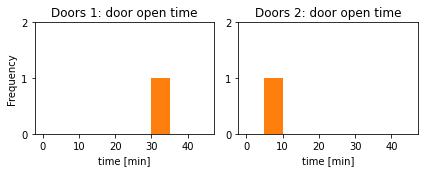

In [17]:
data= [door_open_time_doors_1,door_open_time_doors_2]
xaxes = 'time [min]'
titles = ['Doors 1: door open time','Doors 2: door open time'] 
bins = [range(0,50,5),range(0,50,5)]

f,a = plt.subplots(1,2,figsize=(6, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Frequency')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

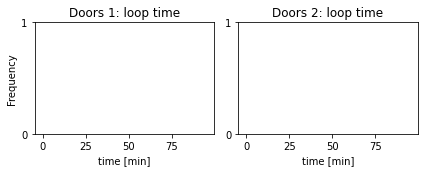

In [18]:
data= [loop_time_doors1,loop_time_doors2]
xaxes = 'time [min]'
titles = ['Doors 1: loop time','Doors 2: loop time'] 
bins = [range(0,100,5),range(0,100,5)]

f,a = plt.subplots(1,2,figsize=(6, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Frequency')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()